<h1 style="font-size:30px;">Training a Vanilla GAN on the Fashion MNIST Dataset</h1>

In this notebook, we will build and train a simple GAN architecture using the Fashion MNIST dataset with the goal of generating realistic-looking images. The architecture covered in this notebook is sometimes referred to as a "Vanilla" GAN and is very similar to the architecture that was proposed by Ian Goodfellow et al. in the <a href="https://arxiv.org/abs/1406.2661" target="_blank">first ever GAN paper</a>. One thing that is worth mentioning upfront is that the original formulation of the loss function from the original GAN paper has been modified for practical reasons. So in this notebook, we will use a formulation that is basically equivalent in many respects to the original formulation but easier to explain and understand. Another thing to remember is that the generator network never sees a single training image. During training, the Generator's parameters are updated based only on the output of the Discriminator, and the only input to the Generator is a random noise vector.


<img src="https://opencv.org/wp-content/uploads/2022/09/c4-gan-architecture-1.png" width=850>

In [3]:
import os
import time
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

from dataclasses import dataclass
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from tqdm.auto import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import (nn, optim)

block_plot = False

plt.rcParams['image.cmap'] = 'gray'

## 1 System Configurations

In [4]:
def set_seed(SEED_VALUE):
    torch.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    np.random.seed(SEED_VALUE)

seed = 7
set_seed(seed)

## 2 Training and Dataset Configurations

The training and data configurations will change slightly. Since we are modeling two networks we should define a separate learning rate for each. We also need to define the size of the noise vector, `Z`, that is used as the input for the Generator network (`LATENT_DIM`).

In [5]:
@dataclass(frozen=True)
class TrainingConfig:
    DEVICE: torch.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    NUM_EPOCHS: int = 101
    LATENT_DIM: int = 100
    BATCH_SIZE: int = 32
    LEARNING_RATE_D: float = 0.0002
    LEARNING_RATE_G: float = 0.0002
    CHECKPOINT_DIR: str = os.path.join('model_checkpoint', 'vanilla_gan_fashion_mnist')

class DatasetConfig:
    IMG_HEIGHT:   int = 28
    IMG_WIDTH:    int = 28
    NUM_CHANNELS: int = 1

## 3 Dataset Preparation

In the code cell below we define a transformation to normalize the images in the range -1 to 1 and create a training dataset.

In [6]:
# Tranforms to convert the pixels between -1 and 1.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

dataset_train = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transform
)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.39MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.80MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.96MB/s]


In [7]:
# The training data loader.
train_dataloader = DataLoader(
    dataset=dataset_train,
    batch_size=TrainingConfig.BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


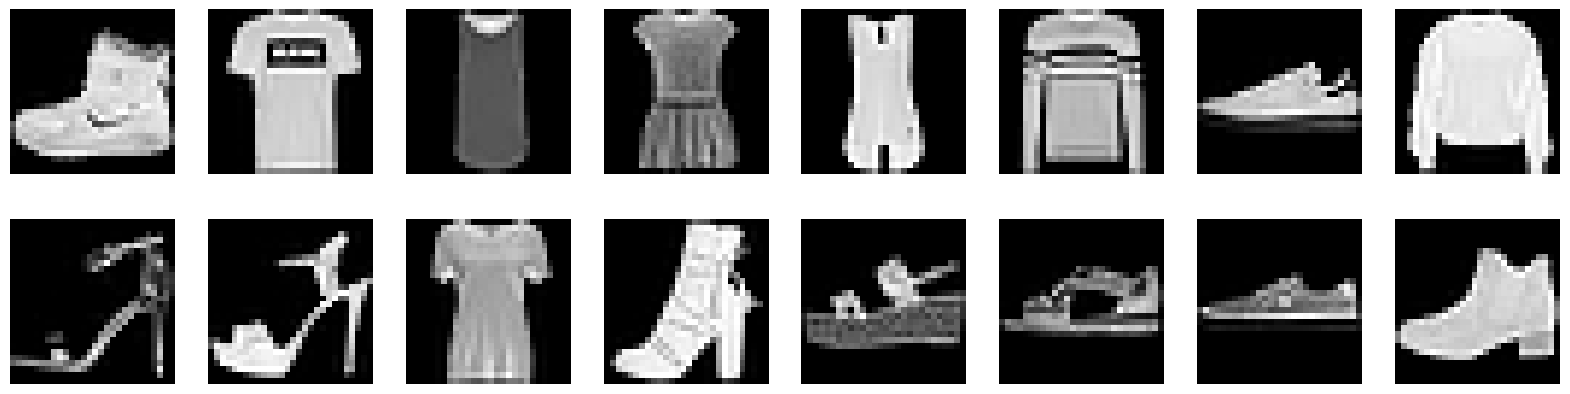

In [9]:
plt.figure(figsize=(20, 5))
nrow = 2
ncol = min(8, int(TrainingConfig.BATCH_SIZE/nrow))
for i in range(nrow*ncol):
        ax = plt.subplot(nrow, ncol, i + 1)
        plt.imshow(dataset_train[i][0].view((28, 28)));
        plt.axis("off")

## 4 The Generator Network

As discussed, the Generator network, $G(z)$, will transform the noise vector into a 2-dimensional image. For the Vanilla GAN, we use dense, fully connected layers to achieve this transformation. The rest of the Generator network consists of `Linear => LeakyReLU` layers with an increasing number of features. We use `LeakyReLU` instead of ReLU as it has proved to be more stable in training GANs. Note that `LeakyReLU` was not part of the initial architecture when GAN papers were published. Also, notice that the activation function of the output layer is `Tanh`. It is through numerous experiments over the years that researchers and practitioners have discovered what works best while training GANs.

Remember that the Fashion MNIST images are 28x28 resolution grayscale images, and we want the Generator to generate such images. The final `Linear` layer has a shape 784x1, so we need to reshape these outputs (while taking the batch size into consideration) into 28x28x1 images using `view()`. Finally, we return this reshaped output (generated image).

In [10]:
class Generator(nn.Module):

    def __init__(self, latent_dim):

        super(Generator, self).__init__()
        self.nz = latent_dim
        self.generator = nn.Sequential(
            nn.Linear(self.nz, 128),
            nn.LeakyReLU(0.2),

            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.generator(x).view(
            -1,
            DatasetConfig.NUM_CHANNELS,
            DatasetConfig.IMG_HEIGHT,
            DatasetConfig.IMG_WIDTH
        )

The output of the next code block shows each layer of the Generator network along with the output shapes.

In [11]:
generator = Generator(TrainingConfig.LATENT_DIM).to(TrainingConfig.DEVICE)

print(generator)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in generator.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in generator.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Generator(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=1024, out_features=784, bias=True)
    (9): Tanh()
  )
)
1,506,448 total parameters.
1,506,448 training parameters.


### 4.1 Generate Random Noise Vector

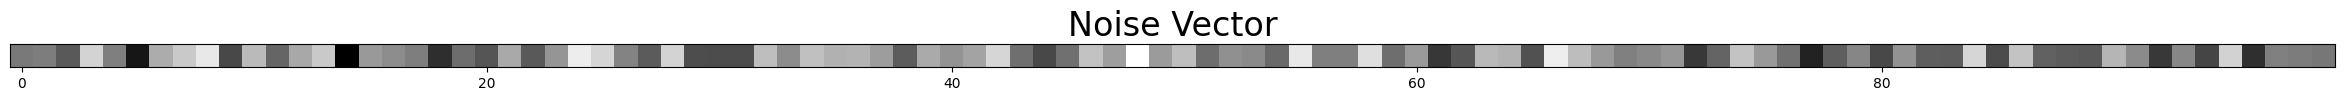

In [12]:
noise = torch.randn(1, TrainingConfig.LATENT_DIM)

plt.figure(figsize=(30, 10))
plt.imshow(noise, cmap='gray')
plt.yticks([])
plt.title("Noise Vector", fontsize=24)
plt.show()

### 4.2 Generate Image using Untrained Network
Let's just confirm that we can generate random image is the correct size using the untrained Generator network.

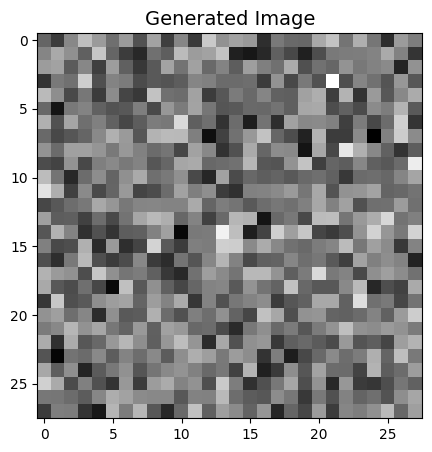

In [13]:
generated_image = generator(noise.to(TrainingConfig.DEVICE))

plt.figure(figsize=(5, 5))
generated_image = generated_image.detach().cpu().view(28, 28)
plt.imshow(np.squeeze(generated_image, -1) * 127.5, cmap='gray')
plt.title('Generated Image', fontsize=14)
plt.show()

## 5 The Discriminator Network

The Discriminator network, $D(x)$, is a very simple binary classification network. However, in this architecture, we will use `Linear` layers rather than convolutional layers, and therefore, we reshape (flatten) the input first. Since this network is exclusively designed for solving a binary classification problem, the activation function of the output layer is `Sigmoid`.

In [14]:
class Discriminator(nn.Module):

    def __init__(self):

        super(Discriminator, self).__init__()

        self.n_input = DatasetConfig.NUM_CHANNELS * DatasetConfig.IMG_HEIGHT * DatasetConfig.IMG_WIDTH

        self.discriminator = nn.Sequential(

            nn.Linear(self.n_input, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = x.view(-1, 784)

        return(self.discriminator(x))

In [15]:
discriminator = Discriminator().to(TrainingConfig.DEVICE)

print(discriminator)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in discriminator.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in discriminator.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Discriminator(
  (discriminator): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
533,505 total parameters.
533,505 training parameters.


## 6 Define the Optimizers

We need to define separate optimizers for the Generator and the Discriminator. We use the `Adam` optimizer for both. As defined earlier, we are using a learning rate of 0.0002 for both optimizers, `beta_1` is 0.5 and `beta_2` is 0.999. These values work well and are define by the `betas` argument in the following code block. GAN training can often be incredibly unstable resulting in the generator not learning anything at all. So, although it is often recommended to experiment with hyperparameters with GANs, it is often the case that people use what has been shown to work for specific architectures.

In [16]:
optimizer_G = optim.Adam(
    generator.parameters(),
    lr=TrainingConfig.LEARNING_RATE_G,
    betas=(0.5, 0.999)
)
optimizer_D = optim.Adam(
    discriminator.parameters(),
    lr=TrainingConfig.LEARNING_RATE_D,
    betas=(0.5, 0.999)
)

## 7 Configure Checkpoints

Create the directories for saving checkpoint files.

In [17]:
if not os.path.exists(TrainingConfig.CHECKPOINT_DIR):
    os.makedirs(TrainingConfig.CHECKPOINT_DIR)

num_versions = len(os.listdir(TrainingConfig.CHECKPOINT_DIR)) + 1
ckpt_version_dir = TrainingConfig.CHECKPOINT_DIR + '/version_' + str(num_versions)
os.makedirs(ckpt_version_dir)

In [18]:
checkpoint_dir = TrainingConfig.CHECKPOINT_DIR
generator_ckpt = os.path.join(ckpt_version_dir, 'generator'+'.pth')
discriminatr_ckpt = os.path.join(ckpt_version_dir, 'discriminator'+'.pth')

## 8 Notional Training Overview

The sequence of images below is from the original research paper, which we have annotated further to describe at a high level the simultaneous training process leading to convergence. Generative adversarial nets are trained by simultaneously updating the discriminative distribution ($D(x)$, blue, dashed line) so that it discriminates between samples from the data generating distribution (black, dotted line) $p_x$ from those of the generative distribution $p_g(G(z))$ (green, solid line). The lower horizontal line is the domain from which $z$ is sampled. The horizontal line above is part of the domain of $x$. The upward arrows show how the mapping $x = G(z)$ imposes the non-uniform distribution $p_g$ on transformed samples. $G(z)$ contracts in regions of high density and expands in regions of low density of $p_g$.

- **Near Convergence**: Consider an adversarial pair near convergence: $p_g$ is similar to $p_{data}$ and $D(x)$ is a partially accurate classifier.

- **Discriminator Update**:  As $D(x)$ is trained to discriminate samples from data, the prediction accuracy increases.

- **Generator Update**: After an update to $G(z)$, gradient of $D(x)$ has guided $G(z)$ to flow to regions that are more likely to be classified as data. The generated distribution (green) is closer to the actual distribution (black).

- **Convergence**: After several steps of training, if $G(z)$ and $D(x)$ have enough capacity, they will reach a
point at which both cannot improve because $p_g = p_{data}$. The Discriminator is unable to differentiate between
the two distributions, i.e. $D(x) = \frac{1}{2}$.


<img src="https://opencv.org/wp-content/uploads/2022/09/c4-gan-notional-training.png">

### 8.1 Discriminator Training Step

The training step for the Discriminator is a standard binary classifier using BCE loss. We use an existing Generator network to generate fake images. We pass both real images from the dataset and fake images from the generator along with the ground truth labels for both sets of images to the Discriminator. The predictions from the Discriminator are then used to compute the binary cross entropy loss. The gradient of the loss w.r.t to the trainable parameters of the Discriminator network are computed and the parameters of the Discriminator network are updated via backpropagation.

<img src="https://opencv.org/wp-content/uploads/2022/09/c4-gan-train-D-1.png">

### 8.2 Generator Training Step

Training the Generator is much different. In this case, we freeze the Discriminator network, and we only generate fake images using the Generator. We feed fake images to the Discriminator but we assign "real" ground truth labels to those images because we want to penalize the Generator for creating poor quality images. The predictions from the Discriminator are then used to compute the binary cross entropy loss. The gradient of the loss w.r.t. to the trainable parameters of the **Generator** network are computed and the parameters of the **Generator** network are updated via backpropagation.

<img src="https://opencv.org/wp-content/uploads/2022/09/c4-gan-train-G-1.png">

## 9 Objective Function for Training a Vanilla GAN

The objective function from the original GAN paper is shown below for reference. This involves a simultaneous maximization and minimization known as a `minimax` formulation.

<img src="https://opencv.org/wp-content/uploads/2022/09/c4-gan-original-objective-function.png" width=600>

However, the problem can be reformulated as a minimization problem using binary cross entropy and flipping the labels during the training of the Generator. There are too many details to cover those steps in this notebook, but we have provided a nice reference <a href="https://www.youtube.com/watch?v=ILpC3b-819Q" target="_blank">here</a> for those who wish to study this in more detail. Here, we will summarize the result.

Recall the formula for binary cross entropy for a finite number of samples, $n$,  where $y$ represents the ground truth labels, and $y'$ represents the predicted labels.

$$\mathcal{L} = \frac{1}{n}\sum_{i=1}^n \ [\ -y_i\ log(y_i') -\ (1-y_i)\ log(1-y_i')\ ] \ \ \ \ \ \ \ \  (1)$$

We can train the **Discriminator** by minimizing this loss function using gradient descent. Remember, the Discriminator is simply a binary classifier that needs to be trained on both types of images (real and fake) and their associated ground truth labels.

$$\mathcal{L^{D}} = - \frac{1}{n}\sum_{i=1}^n\  [\ y_i\ log(D(x_i)) +\ (1-y_i)\ log(1-D(G(z_i))) \ ]$$


So let's now see how we can also use this formulation to train the **generator**. The goal of the Generator is to fool the Discriminator, so to train the **Generator**, we will only feed generated images to the Discriminator, but we assign true labels ($y_i = 1$) to these images to compute the **Discriminator** loss which is used to update the Generator. This may seem counterintuitive at first, but remember the goal of the Generator is to generate images that look real, so the Generator loss is a measure of how far the generated images are from real images. The binary cross entropy loss function for the **generator** reduces to the following since the 2nd term in equation (1) above is always zero (we assign "real" labels to the generated images that are passed to the Discriminator, $y_i = 1$). In the equation below, fake images, $G(z)$ are passed to the Discriminator, so $D(G(z))$ prepresents the predicted value of the Discriminaor for generated (fake) images, and the loss for the Generator is computed based on true labels.

$$\mathcal{L^{G}} = - \frac{1}{n} \sum_{i=1}^n \ [\  y_i\ log(D(G(z_i))) \ ]$$


**Note:** It is important to emphasize that **both** the Generator and Discriminator are trained from the classification outputs of the Discriminator.

### 9.1 Loss Function

As discussed above, the loss function we will use for **both** networks is binary cross entropy. However, for the **Generator**, the loss function is only evaluated for fake images with "real" labels. The implementation in the sections that follow will make this clear.

In [19]:
# Binary Cross Entropy initializer.
BCE = nn.BCELoss()

In [20]:
def loss_func(y_true, y_pred):

    loss = BCE(y_pred, y_true)

    return loss

## 10 GAN Training

### 10.1 `train_step()` Function

We are now ready to define a custom `train_step()` function that will perform the iterative, two-step training process.

In [21]:
def train_step(real_images):

    optimizer_G.zero_grad()
    optimizer_D.zero_grad()

    # Create ground truth labels for real and fake data.
    labels = torch.cat(
        (torch.ones(TrainingConfig.BATCH_SIZE, 1), # Labels for real data
         torch.zeros(TrainingConfig.BATCH_SIZE, 1) # Labels for fake data
        ), dim=0
    ).to(TrainingConfig.DEVICE)

    # We want to fool the discriminator, so we create grond truth labels for
    # real images even though we feed the discriminator with fake images.
    misleading_labels = torch.ones(TrainingConfig.BATCH_SIZE, 1).to(TrainingConfig.DEVICE)

    noise = torch.randn(
        TrainingConfig.BATCH_SIZE,
        TrainingConfig.LATENT_DIM
    ).to(TrainingConfig.DEVICE)

    #-----------------------
    # Train Discriminator.
    #-----------------------

    # Generate fake images.
    fake_images = generator(noise)

    # Predicted labels from discriminator for real images.
    y_pred_real = discriminator(real_images)

    # Predicted labels from discriminator for fake images.
    y_pred_fake = discriminator(fake_images)

    # Concatenate predictions for real and fake input data.
    y_pred_D = torch.cat((y_pred_real, y_pred_fake), dim=0)

    # Compute the discriminator loss.
    D_loss = loss_func(labels, y_pred_D)

    # Discriminator step.
    D_loss.backward()
    optimizer_D.step()

    #-------------------
    # Train Generator.
    #-------------------

    # Generate fake images.
    fake_images = generator(noise)

    # Predicted labels from discriminator for fake images.
    y_pred_fake = discriminator(fake_images)

    # Compute the generator loss.
    G_loss = loss_func(misleading_labels, y_pred_fake)

    # Generator step.
    G_loss.backward()
    optimizer_G.step()

    return D_loss, G_loss

### 10.2  Convenience Function to Display Generated Images during Training

Here we created a convenience function to display generated images that we can monitor during the training process. We specifically use a fixed noise vector so that we generate the same set of images at each epoch so that it is easier to gauge how well the GAN is training.

In [22]:
# Create a fixed noise vector for generating examples images during training.
fixed_noise = torch.randn(int(TrainingConfig.BATCH_SIZE/2),
                           TrainingConfig.LATENT_DIM,
                          )

def plot_images(model):

    model.eval()
    with torch.no_grad():
        images = model(fixed_noise.to(TrainingConfig.DEVICE))
        images = images.detach().cpu().view((images.shape[0], 28, 28))

    plt.figure(figsize=(20, 4))

    nrow = 2
    ncol = int(images.shape[0] / nrow)

    for i, image in enumerate(images):
        col = int(TrainingConfig.BATCH_SIZE / 2)
        plt.subplot(nrow, ncol, i+1)
        plt.imshow(np.squeeze(image, -1) * 127.5, cmap='gray')
        plt.axis('off')

    plt.show();

### 10.3 `train()` Function

In [23]:
G_LOSS = []
D_LOSS = []

def train(dataloader, epochs):

    for epoch in range(epochs):

        generator.train()
        discriminator.train()
        start = time.time()
        i = 0
        D_loss_list, G_loss_list = [], []

        for _, data in tqdm(enumerate(dataloader), total=int(len(dataloader))):

            image_batch, _ = data
            image_batch = image_batch.to(TrainingConfig.DEVICE)

            i += 1

            D_loss, G_loss = train_step(image_batch)

            D_loss_list.append(D_loss)
            G_loss_list.append(G_loss)

        if (epoch + 1) % 5 == 0:
            torch.save(generator, generator_ckpt)
            torch.save(discriminator, discriminatr_ckpt)

        epoch_D_loss = sum(D_loss_list)/len(D_loss_list)
        epoch_G_loss = sum(G_loss_list)/len(G_loss_list)

        D_LOSS.append(epoch_D_loss.detach().cpu())
        G_LOSS.append(epoch_G_loss.detach().cpu())

        print('\n')
        print(f"Time for epoch {epoch + 1} is {time.time()-start} sec")
        print(f"Generator loss: {epoch_G_loss:.3f}, Discriminator loss: {epoch_D_loss:.3f}")

        plot_images(generator)

## 11 Train the GAN

In [24]:
train(train_dataloader, TrainingConfig.NUM_EPOCHS)

Output hidden; open in https://colab.research.google.com to view.

## 12 Plot the Training Results

In [25]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.NUM_EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=block_plot)
    plt.close()


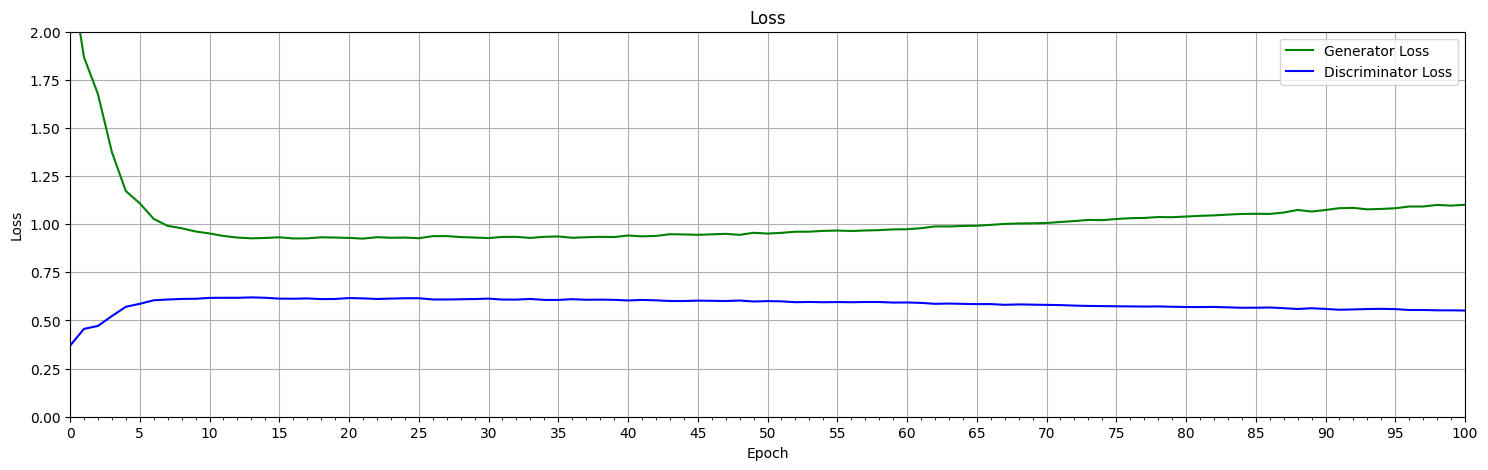

In [26]:
# Retrieve the training results.
plot_results([G_LOSS, D_LOSS],
            ylabel="Loss",
            ylim=[0, 2],
            metric_name=["Generator Loss", "Discriminator Loss"],
            color=["g", "b"]);

## 13 Generating Images using Trained Model

In [28]:
trained_generator = torch.load(generator_ckpt, weights_only=False)

In [29]:
def generate_images(model, noise):

    model.eval()

    with torch.no_grad():
        images = model(noise.to(TrainingConfig.DEVICE))
        images = images.cpu().view((images.shape[0]), DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH)

    plt.figure(figsize=(25, 10))

    nrow = 4
    ncol = int(noise.shape[0] / nrow)

    for i, image in enumerate(images):
        plt.subplot(nrow, ncol, i+1)
        plt.imshow(np.squeeze(image, -1) * 127.5, cmap='gray')
        plt.axis('off')

    plt.show()


In [30]:
noise = torch.randn(TrainingConfig.BATCH_SIZE, TrainingConfig.LATENT_DIM)

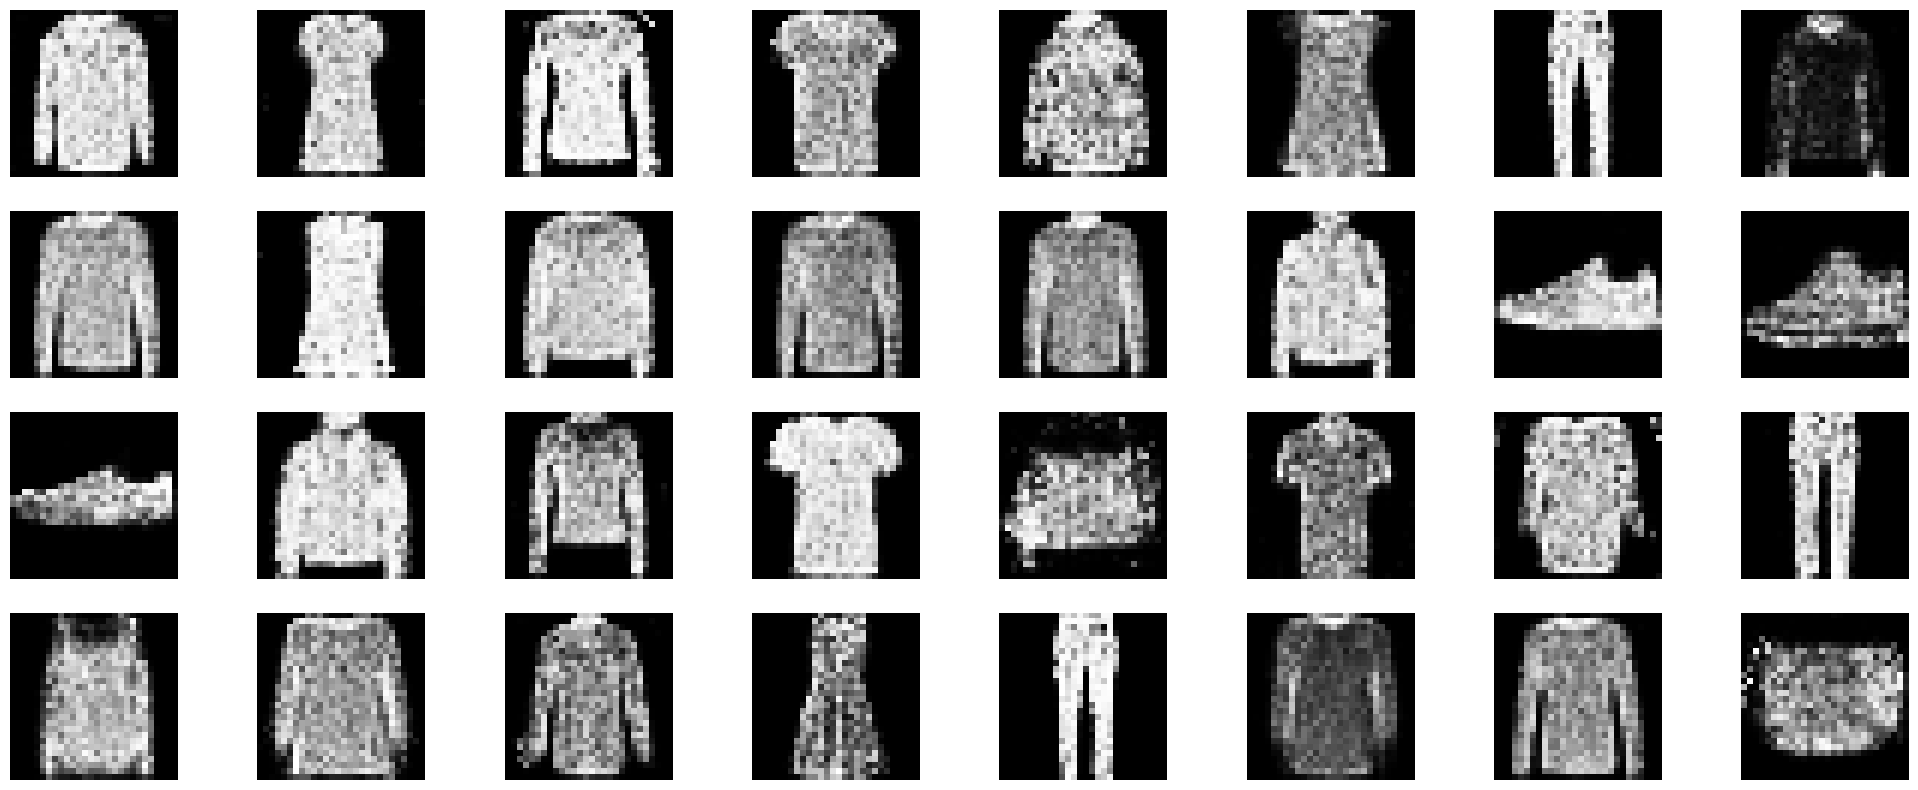

In [31]:
generate_images(trained_generator, noise)

## 14 Conclusion

This notebook covered the basic concepts associated with GANs and implemented a simple "Vanilla" GAN architecture. The goal was not to produce high-quality images but rather to use a simple architecture on a small dataset to provide a concrete example of developing and training a simple GAN to provide a foundation for further learning.